In [3]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
def load_mnist(dim=3, data='mnist'):
    img_rows, img_cols = 28, 28
    
    (train_X, train_y), (test_X, test_y) = mnist.load_data()
    
    train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
    test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
        
    train_X = train_X.astype('float32') / 255
    test_X = test_X.astype('float32') / 255
    train_y = np.eye(10)[train_y]
    test_y = np.eye(10)[test_y]
    
    return  train_X, test_X, train_y, test_y

In [0]:
def plot_mnist_conditional(n_ex=10,dim=(2, 5), figsize=(8,4), labels=range(10)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    label_batch = np.eye(10)[np.arange(10)]
    generated_images = generator.predict([noise, label_batch])

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1], i+1)
        img = generated_images[i,:,:, 0]
        plt.imshow(img, cmap='binary')
        plt.title(labels[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
from keras.layers import Input, concatenate
from keras.layers.core import Reshape, Dense, Activation
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [0]:
def Generator():
    
    nch=200
    # ランダムなノイズ
    model_input = Input(shape=[100])
    # 0~9のどの数字の画像かのラベル情報
    cond = Input(shape=[10])
    # 上記2つを結合する
    cond_input = concatenate([model_input, cond], axis=-1) 
    
    x = Dense(nch*14*14, kernel_initializer='glorot_normal')(cond_input) # 110 -> 200*14*14
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Reshape( [14, 14, nch] )(x) # 200*14*14 -> 14x14x200
    x = UpSampling2D(size=(2, 2))(x) # 14x14x200 -> 28x28x200
    x = Conv2D(int(nch/2), (3, 3), padding='same', 
               kernel_initializer='glorot_uniform')(x) # 28x28x200 -> 28x28x100
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nch/4), (3, 3), padding='same', 
               kernel_initializer='glorot_uniform')(x) # 28x28x100 -> 28x28x50
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(1, (1, 1), padding='same', 
               kernel_initializer='glorot_uniform')(x) # 28x28x50 -> 28x28x1
    model_output = Activation('sigmoid')(x)
    model = Model([model_input, cond], model_output)
    # model.summary()
    
    return model

In [0]:
from keras.layers import Input, concatenate, Lambda
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K

In [0]:
def Discriminator(shape, dropout_rate=0.25, opt=Adam(lr=1e-4)):
    
    model_input = Input(shape=shape)
    cond = Input(shape=[10])
    
    # ここでラベル情報をreshape
    cond_reshape = Reshape( [1, 1, 10] )(cond) # 1x1x10
    cond_reshape = Lambda(lambda x: K.ones([28, 28, 10])*x)(cond_reshape) # 1x1x10 -> 28x28x10
    cond_input = concatenate([model_input, cond_reshape], axis=-1) # 28x28x11
    
    x = Conv2D(256, (5, 5), padding = 'same', 
               kernel_initializer='glorot_uniform', 
               strides=(2, 2))(cond_input) # 28x28x11 -> 14x14x256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(512, (5, 5), padding = 'same', 
               kernel_initializer='glorot_uniform', 
               strides=(2, 2))(x) # 14x14x256 -> 7x7x512
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x) # 7x7x512 -> 7*7*512
    x = Dense(1024)(x) # 7*7*512 -> 1024
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x) # 1024 -> 512
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x) # 512 -> 256
    x = LeakyReLU(0.2)(x)
    x = Dropout(dropout_rate)(x)
    model_output = Dense(2,activation='softmax')(x) # 256 -> 2
    model = Model([model_input, cond], model_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

In [0]:
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import Model

In [0]:
def combined_network(generator, discriminator, opt=Adam(lr=1e-3)):
    gan_input = Input(shape=[100])
    cond = Input(shape=[10])
    x = generator([gan_input, cond])
    gan_output = discriminator([x, cond])
    model = Model([gan_input, cond], gan_output)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    # model.summary()
    
    return model

In [0]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [0]:
from tqdm import tqdm

def train(step=3000, BATCH_SIZE=128):

    for e in tqdm(range(step)):  
        
        image_indexes = np.random.randint(0,X_train.shape[0],size=BATCH_SIZE)
        image_batch = X_train[image_indexes,:,:,:]  
        label_batch = y_train[image_indexes]  
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict([noise_gen, label_batch])
        
        make_trainable(discriminator,True)
        
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        label_batch = np.concatenate((label_batch, label_batch))
        
        
        discriminator.train_on_batch([X, label_batch], y)
        
        make_trainable(discriminator,False)
    
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        label_batch2 = np.random.randint(0, 10, size=BATCH_SIZE)
        label_batch2 = np.eye(10)[label_batch2]
             
        GAN.train_on_batch([noise_tr, label_batch2], y2 )

In [16]:
# network 
X_train, _, y_train, _ = load_mnist()
generator = Generator()
discriminator = Discriminator(X_train.shape[1:])
make_trainable(discriminator, False)
GAN = combined_network(generator, discriminator)

11493376/11490434 [==============================] - 2s 0us/step


In [17]:
train()

100%|██████████| 3000/3000 [25:10<00:00,  2.00it/s]


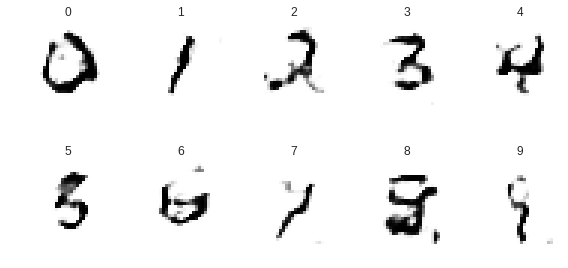

In [0]:
plot_mnist_conditional()